# データのダウンロード

In [68]:
from torchvision.datasets import VOCDetection

dataset = VOCDetection(root='dataset', year='2007', image_set='trainval', download=False)

In [158]:
import matplotlib
from IPython.display import display
%matplotlib inline

#display(data[0][0])

In [70]:
data[0][1]['annotation']['object']

{'name': 'car',
 'pose': 'Rear',
 'truncated': '0',
 'difficult': '0',
 'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}

# データセット

In [1]:
import torch

class MultiLabelTransform:
    def __init__(self, label_dict):
        self.label2index = label_dict

    def __call__(self, annotate_dict):
        label = [0] * len(self.label2index.keys())
        objs = annotate_dict['annotation']['object']
        if isinstance(objs, dict):
            label[self.label2index[objs['name']]] = 1
        else:
            for obj in objs:
                label[self.label2index[obj['name']]] = 1
                
        return torch.FloatTensor(label)

In [2]:
# label2index
labels = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',\
          'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
label2index = {label: i for i, label in enumerate(labels)}

In [3]:
from torchvision import transforms


IMAGE_SIZE = 256
image_transform = transforms.Compose([
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE), pad_if_needed=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    MultiLabelTransform(label2index)
])

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection

BATCH_SIZE = 32
dataset = VOCDetection(root='dataset', year='2007', image_set='train', download=False, transform=image_transform, target_transform=target_transform)
train_loader = DataLoader(dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True
                          )

In [5]:
dev_dataset = VOCDetection(root='dataset', year='2007', image_set='val', download=False, transform=image_transform, target_transform=target_transform)
dev_loader = DataLoader(dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False
                          )

In [6]:
# Reference
# https://github.com/bluesky314/Cyclical_LR_Scheduler_With_Decay_Pytorch

import math
from bisect import bisect_right,bisect_left

import torch
import numpy as np
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

class CyclicCosAnnealingLR(_LRScheduler):
    """
    
    Implements reset on milestones inspired from CosineAnnealingLR pytorch
    
    Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:
    .. math::
        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))
    When last_epoch > last set milestone, lr is automatically set to \eta_{min}
    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. Note that this only
    implements the cosine annealing part of SGDR, and not the restarts.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        milestones (list of ints): List of epoch indices. Must be increasing.
        decay_milestones(list of ints):List of increasing epoch indices. Ideally,decay values should overlap with milestone points
        gamma (float): factor by which to decay the max learning rate at each decay milestone
        eta_min (float): Minimum learning rate. Default: 1e-6
        last_epoch (int): The index of last epoch. Default: -1.
        
        
    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer,milestones,decay_milestones=None, gamma=0.5,eta_min=1e-6, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.eta_min = eta_min
        self.milestones=milestones
        self.milestones2=decay_milestones
        
        self.gamma = gamma
        super(CyclicCosAnnealingLR, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        
        if self.last_epoch >= self.milestones[-1]:
            return [self.eta_min for base_lr in self.base_lrs]

        idx = bisect_right(self.milestones,self.last_epoch)
        
        
        
        left_barrier = 0 if idx==0 else self.milestones[idx-1]
        right_barrier = self.milestones[idx]


        width = right_barrier - left_barrier
        curr_pos = self.last_epoch- left_barrier 
        
        
        if self.milestones2:
            return [self.eta_min + ( base_lr* self.gamma ** bisect_right(self.milestones2,self.last_epoch)- self.eta_min) *
                   (1 + math.cos(math.pi * curr_pos/ width)) / 2
                    for base_lr in self.base_lrs]
        else:
            return [self.eta_min + (base_lr - self.eta_min) *
               (1 + math.cos(math.pi * curr_pos/ width)) / 2
                for base_lr in self.base_lrs]

In [7]:
from torch import nn

class MultiLabelImageClassification(nn.Module):
    def __init__(self, pretrained_model, output_dim):
        super(MultiLabelImageClassification, self).__init__()
        self.image_encoder = pretrained_model
        layers = [layer for layer in pretrained_model._modules.keys()]
        last_layer = pretrained_model._modules[layers[-1]]
        if isinstance(last_layer, torch.nn.modules.container.Sequential):
            sequential_layers = [layer for layer in last_layer._modules.keys()]
            inter_dim = last_layer._modules[sequential_layers[-1]].out_features
        else:
            inter_dim = pretrained_model._modules[layers[-1]].out_features
        self.linear = nn.Linear(inter_dim, output_dim)
        
    def forward(self, input):
        return self.linear(self.image_encoder(input))

In [8]:
from sklearn.metrics import accuracy_score

def evaluate(model, loader):
    model.eval()
    with torch.no_grad():
        predict = np.array([])
        target_label = np.array([]) 
        for batch in loader:
            input, target = batch
            target = target.numpy().reshape(-1)
            target_label = np.hstack((target_label, target))
            if use_cuda and torch.cuda.is_available():
                input = input.cuda()

            forward = model(input)
            if use_cuda and torch.cuda.is_available():
                forward = forward.cpu()
            forward = forward.numpy()
            forward = np.vectorize(lambda x:1 if x >= 0.5 else 0)(forward).reshape(-1)
            predict = np.hstack((predict, forward))
            
    accuracy = accuracy_score(target_label, predict)
    return accuracy

In [9]:
import torchvision.models as models
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR


lr = 1e-1
pretrained_model = models.vgg19_bn(pretrained=True)
model = MultiLabelImageClassification(pretrained_model, output_dim=20)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MultiLabelMarginLoss()
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
# scheduler = StepLR(optimizer, 5, gamma=0.1)
scheduler = CyclicCosAnnealingLR(optimizer,milestones=[10, 30, 50, 70, 80, 90],decay_milestones=[30, 70, 80, 90],eta_min=1e-6)

In [10]:
use_cuda = True

model.cpu()
if use_cuda and torch.cuda.is_available():
    model.cuda()

In [11]:
# mlflow setting
import mlflow
from mlflow import pytorch

EXPERIMENT_NAME = 'captum-exp'
mlflow.set_tracking_uri('http://localhost:5000')
try:
    mlflow.create_experiment(EXPERIMENT_NAME)
except:
    print(f'Experiment name "{EXPERIMENT_NAME}" is already created')
    
mlflow.set_experiment(EXPERIMENT_NAME)

Experiment name "captum-exp" is already created


In [ ]:
import warnings
warnings.filterwarnings('ignore')

with mlflow.start_run():
    # logging parameters
    mlflow.log_param("image_size", IMAGE_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("lr", lr)
    
    temp_score = 0.0
    remain_count = 0
    upper_count = 101
    for epoch in range(1, 101):
        print(f'Epoch: {epoch}')
        for batch in train_loader:
            input, target = batch
            if use_cuda and torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            forward = model(input)
            loss = criterion(forward, target)
            mlflow.log_metric('Loss', loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        score = evaluate(model, dev_loader)
        model.train()
        print(f'Dev Exact Match Ratio: {score}')
        mlflow.log_metric('Exact Match Ratio', score)
        if score > temp_score:
            temp_score = score
            remain_count = 0
        else:
            remain_count += 1
            if remain_count >= upper_count:
                print(f'Metrics not improved')
                print('Early Stopping')
                break
            
        # save model every epoch
        pytorch.log_model(model, f"models/{epoch}")
        scheduler.step()

# 評価

In [13]:
import os
import sys

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

from PIL import Image

global DATASET_YEAR_DICT
DATASET_YEAR_DICT = {
    '2012': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '6cd6e144f989b92b3379bac3b3de84fd',
        'base_dir': 'VOCdevkit/VOC2012'
    },
    '2011': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar',
        'filename': 'VOCtrainval_25-May-2011.tar',
        'md5': '6c3384ef61512963050cb5d687e5bf1e',
        'base_dir': 'TrainVal/VOCdevkit/VOC2011'
    },
    '2010': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar',
        'filename': 'VOCtrainval_03-May-2010.tar',
        'md5': 'da459979d0c395079b5c75ee67908abb',
        'base_dir': 'VOCdevkit/VOC2010'
    },
    '2009': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar',
        'filename': 'VOCtrainval_11-May-2009.tar',
        'md5': '59065e4b188729180974ef6572f6a212',
        'base_dir': 'VOCdevkit/VOC2009'
    },
    '2008': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2008/VOCtrainval_14-Jul-2008.tar',
        'filename': 'VOCtrainval_11-May-2012.tar',
        'md5': '2629fa636546599198acfcfbfcf1904a',
        'base_dir': 'VOCdevkit/VOC2008'
    },
    '2007': {
        'url': 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar',
        'filename': 'VOCtrainval_06-Nov-2007.tar',
        'md5': 'c52e279531787c972589f7e41ab4ae64',
        'base_dir': 'VOCdevkit/VOC2007'
    }
}

In [14]:
# Test向けデータセット作成
from torchvision.datasets.vision import VisionDataset
import collections

class TestVOCDetection(VisionDataset):
    def __init__(self,
                 root,
                 year='2012',
                 image_set='train',
                 download=False,
                 transform=None,
                 target_transform=None,
                 transforms=None):
        super(TestVOCDetection, self).__init__(root, transforms, transform, target_transform)
        self.year = year
        self.url = DATASET_YEAR_DICT[year]['url']
        self.filename = DATASET_YEAR_DICT[year]['filename']
        self.md5 = DATASET_YEAR_DICT[year]['md5']
        self.image_set = 'test'

        base_dir = DATASET_YEAR_DICT[year]['base_dir']
        voc_root = os.path.join(self.root, base_dir)
        image_dir = os.path.join(voc_root, 'JPEGImages')
        annotation_dir = os.path.join(voc_root, 'Annotations')

        if download:
            download_extract(self.url, self.root, self.filename, self.md5)

        if not os.path.isdir(voc_root):
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        splits_dir = os.path.join(voc_root, 'ImageSets/Main')

        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')

        with open(os.path.join(split_f), "r") as f:
            file_names = [x.strip() for x in f.readlines()]

        self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
        self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
        assert (len(self.images) == len(self.annotations))
        
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is a dictionary of the XML tree.
        """
        img = Image.open(self.images[index]).convert('RGB')
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.images)
    
    def parse_voc_xml(self, node):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            voc_dict = {
                node.tag:
                    {ind: v[0] if len(v) == 1 else v
                     for ind, v in def_dic.items()}
            }
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


In [15]:
test_dataset = TestVOCDetection(root='dataset/test', year='2007', image_set='test', download=False, transform=image_transform, target_transform=target_transform)
test_loader = DataLoader(test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False
                          )

In [16]:
test_score = evaluate(model, test_loader)

In [17]:
print(test_score)

0.9656502423263328


# Captumの実験

In [18]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

In [137]:
for b in test_loader:
    break

In [157]:
model.cpu()

In [139]:
i = b[0]
i = i
out = model(i)

In [140]:
idx = 15

In [141]:
def print_format(array, vec, d):
    for i, (k, l, v) in enumerate(zip(d.keys(), vec, array)):
        print('{}\t{}\t{}\t{:f}'.format(i, k, int(l), v))

In [142]:
sigmoid = nn.Sigmoid()
res_num = sigmoid(out[idx]).detach().numpy()
l = b[1][idx]
print_format(res_num, l, label2index)

0	person	0	0.000000
1	bird	0	0.000000
2	cat	1	1.000000
3	cow	0	0.000000
4	dog	0	0.000000
5	horse	0	0.000000
6	sheep	0	0.000000
7	aeroplane	0	0.000000
8	bicycle	0	0.000000
9	boat	0	0.000000
10	bus	0	0.000000
11	car	0	0.000004
12	motorbike	0	0.000000
13	train	0	0.000000
14	bottle	0	0.000000
15	chair	0	0.000000
16	diningtable	0	0.000000
17	pottedplant	0	0.000000
18	sofa	0	0.000000
19	tvmonitor	0	0.000000


In [149]:
input_tensor = b[0][idx]
input_tensor = input_tensor.reshape(1, 3, 256, 256)

In [150]:
# Integrated Gradients
model.eval()
baseline = torch.zeros(1, 3, 256, 256)
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input_tensor, baseline, target=2, return_convergence_delta=True)
print('Convergence Delta: ', delta)

Convergence Delta:  tensor([0.1131])


In [109]:
# GradientShape
model.eval()
baseline_dist = torch.randn(10, 3, 256, 256)
gs = GradientShap(model)
attributions, delta = gs.attribute(input_tensor, stdevs=0.09, n_samples=5, baselines=baseline_dist,
                                   target=0, return_convergence_delta=True)
print('Convergence Delta: ', delta)

Convergence Delta:  tensor([-10.9886,  26.4907,  39.7513,  11.4225,  -2.0233])


In [151]:
import cv2
import numpy as np
import math

original = input_tensor[0].numpy().transpose((1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


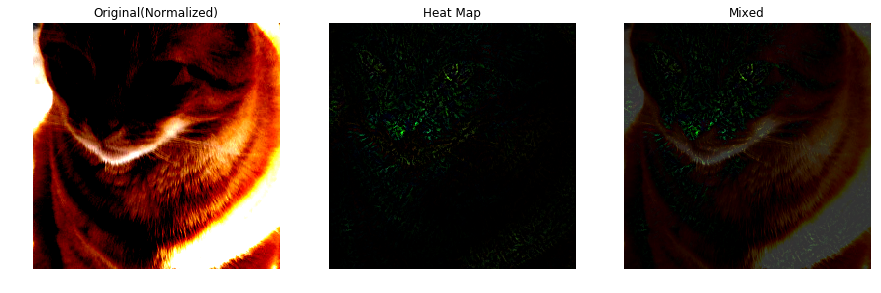

In [156]:
k = attributions[0].numpy().transpose((1, 2, 0))
k = np.maximum(k, 0)
#k = (k - np.min(k)) / (np.max(k) - np.min(k))
k = (k / k.max())
#k = cv2.applyColorMap(np.uint8(255 * k), cv2.COLORMAP_JET)
k = np.float32(k)

plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.title('Original(Normalized)')
plt.axis('off')
plt.imshow(original)

plt.subplot(132)
plt.title('Heat Map')
plt.axis('off')
plt.imshow(k, cmap='jet', alpha=1.0)

plt.subplot(133)
plt.title('Mixed')
plt.axis('off')
plt.imshow(original)
plt.imshow(k, cmap='jet', alpha=0.8)